<a href="https://colab.research.google.com/github/crypton007/ObjectDetection/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="10"> **Gadget Detection using Transfer Learning**

In [ ]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import tensorflow as tf
import pandas as pd
import numpy as np
import imutils
from imutils import paths
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CIProject/Dataset/

/content/drive/MyDrive/CIProject/Dataset


<font size="6"> Setting up paths for the dataset

Define a path on google drive that contains base path and path to training and validationimage along with it's annotations.

I have used makesense.ai to annotate dataset and then export annotated csv to prepare trainingn and validation dataset.

In [ ]:
base_path="/content/drive/MyDrive/CIProject/Dataset"
images=os.path.sep.join([base_path,'images'])
annotations=os.path.sep.join([base_path,'annotations.csv'])
validation_images = os.path.sep.join([base_path,'validation_images'])
validation_annotations=os.path.sep.join([base_path,'validation_annotations.csv'])

<font size="6"> **Preparing Training and Validation Datasets**

Performing one hot encoding for classification.
I have done one hot encoding manual instead of using pd.get_dummies so that I can convert the result back to it's original label

In [ ]:
#Defining class labels

classes = 10

label_to_class_names = {
    0: 'Controller',
    1: 'Keyboard',
    2: 'Mouse',
    3: 'Wifi',
    4: 'Monitor',
    5: 'Cpu',
    6: 'Headphones',
    7: 'Laptop',
    8: 'Smartphone',
    9: 'Smartwatch'
}

#One hot encoded labels
encode_classname = {}

for label, class_name in label_to_class_names.items():
  one_hot_encoding = [0] * len(label_to_class_names)
  one_hot_encoding[label] = 1

  # Add the one-hot encoding to the dictionary
  encode_classname[class_name] = one_hot_encoding

print(encode_classname)


{'Controller': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Keyboard': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'Mouse': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'Wifi': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'Monitor': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'Cpu': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'Headphones': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'Laptop': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'Smartphone': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'Smartwatch': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}


Load Train and Validation dataset

In [ ]:
#Load Dataset from drive
#I have created train and validation dataset seperately and not used train test split so as to include all class in the
#validation dataset as well

df = pd.read_csv(annotations)
valdf = pd.read_csv(validation_annotations)
df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,Keyboard,24,433,1050,363,1405207_0__89426583_7812009655.jpg,1280,1280
1,Mouse,1108,452,169,326,1405207_0__89426583_7812009655.jpg,1280,1280
2,Keyboard,35,590,1505,754,20171225173619.jpg,2000,2000
3,Mouse,1567,712,359,567,20171225173619.jpg,2000,2000
4,Keyboard,51,378,1152,632,4X30M39496_1_Supersize.jpg,1500,1500


In [ ]:


def prepare_dataset(df,images, encode_classname):
  # Initialize empty lists for image data, bounding box coordinates, and labels
  imgarray=[]
  bbox=[]
  labels=[]

  # Iterate over the rows of the data DataFrame
  for idx, row in df.iterrows():
    # Extract the image name, label, and bounding box coordinates from the DataFrame
    image_name = row.iloc[5]
    label = row.iloc[0]
    bboxX = row.iloc[1]
    bboxY = row.iloc[2]
    width = row.iloc[3]
    height = row.iloc[4]

    #Adjusting boundary boxes in resized image
    imagepaths=os.path.sep.join([images,image_name])
    image=cv2.imread(imagepaths)
    (h,w)=image.shape[:2]

    # Adjust the bounding box coordinates to the new dimensions of the resized image
    bboxX = float(bboxX) / w
    bboxY = float(bboxY) / h 
    height = float(height) / w
    width = float(width) / h

    # Load and resize the image, then convert it to a NumPy array
    image=load_img(imagepaths,target_size=(224,224)) 
    image=img_to_array(image)

    # Append the image data, bounding box coordinates, and one-hot encoded label to the respective lists
    imgarray.append(image)
    bbox.append((bboxX,bboxY,height,width))
    labels.append(encode_classname[label])

  # Normalize the image data
  imgarray=np.array(imgarray,dtype='float32') / 255.0
  bbox=np.array(bbox,dtype='float32')
  labels = np.array(labels)

  return imgarray, bbox, labels

Preparing the training dataset for object detection and preprocessing the images

In [ ]:
# Prepare the training dataset
train_imgdata, train_bbox, train_labels = prepare_dataset(df,images, encode_classname)
train_imgdata.shape, train_bbox.shape, train_labels.shape

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


((184, 224, 224, 3), (184, 4), (184, 10))

Preparing the validation dataset for object detection and preprocessing the images

In [ ]:
# Prepare the Validation dataset
val_imgdata, val_bbox, val_labels = prepare_dataset(valdf,validation_images, encode_classname)
val_imgdata.shape, val_bbox.shape, val_labels.shape

((39, 224, 224, 3), (39, 4), (39, 10))

<font size="6">**Performing Transfer learning on MobilenetV2 and VGG16 with pretrained weights on imagenet**

<font size="6"> MobilenetV2

Loading pretrained MobileNetV2 model and then performing transfer learning on our custom dataset by extending it with our own layers

In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_shape=(224,224,3))
mobilenet.trainable = False

# Customize the layers of the model
x = mobilenet.output
x = Flatten()(x)

# Add fully-connected layers to the model
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Add an output layer for the bounding box predictions
bbox_output = Dense(4, activation='sigmoid', name='bounding_box')(x)

# Add fully-connected layers to the model
l = Dense(512, activation="relu")(x)
l = Dropout(0.2)(l)
l = Dense(128, activation="relu")(l)
l = Dropout(0.2)(l)

# Add an output layer for the class label predictions
label_output = Dense(10, activation='softmax', name='class_label')(l)

# Create a model with the customized layers
mobilenet = Model(mobilenet.input, [label_output, bbox_output])

# Print a summary of the model
mobilenet.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

Training the mobilenetV2 model on our custom dataset

In [ ]:
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

lossWeights = {
	"class_label": 1,
	"bounding_box": 5
}

mobilenet.compile(
    optimizer=Adam(0.00001), 
    loss=losses,
    loss_weights=lossWeights,metrics=['accuracy']
)
# train model for 100 epochs
historymobilenet = mobilenet.fit(
    train_imgdata, 
    [train_labels, train_bbox],
    validation_data=(val_imgdata,[val_labels,val_bbox]),
    batch_size = 16, 
    epochs = 100,
    verbose = 1,
)

Epoch 1/100
12/12 [==============================] - 12s 173ms/step - loss: 3.4000 - class_label_loss: 2.3322 - bounding_box_loss: 0.2135 - class_label_accuracy: 0.0924 - bounding_box_accuracy: 0.3750 - val_loss: 2.8425 - val_class_label_loss: 2.2852 - val_bounding_box_loss: 0.1115 - val_class_label_accuracy: 0.1282 - val_bounding_box_accuracy: 0.6410
Epoch 2/100
12/12 [==============================] - 0s 35ms/step - loss: 2.8778 - class_label_loss: 2.3541 - bounding_box_loss: 0.1047 - class_label_accuracy: 0.1033 - bounding_box_accuracy: 0.6576 - val_loss: 2.7194 - val_class_label_loss: 2.3038 - val_bounding_box_loss: 0.0831 - val_class_label_accuracy: 0.1282 - val_bounding_box_accuracy: 0.6410
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 2.7348 - class_label_loss: 2.3385 - bounding_box_loss: 0.0793 - class_label_accuracy: 0.1087 - bounding_box_accuracy: 0.7391 - val_loss: 2.6725 - val_class_label_loss: 2.2646 - val_bounding_box_loss: 0.0816 - val_class_l

Plotting the Training loss and validation loss graph

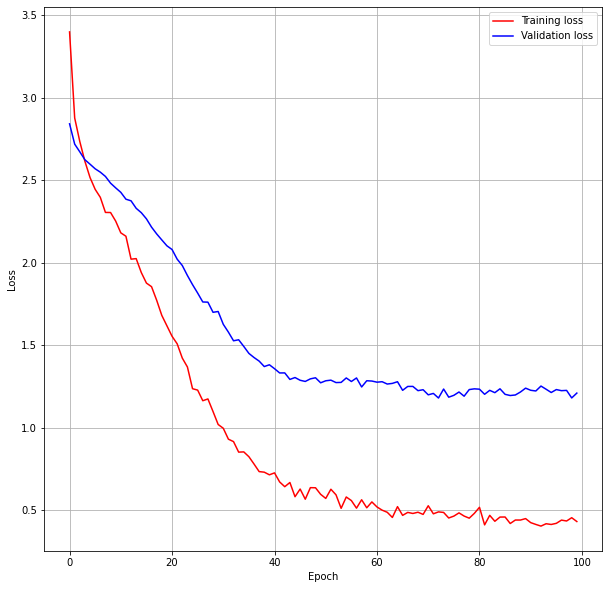

In [ ]:
plt.figure(figsize=(10, 10))

loss = historymobilenet.history['loss']
val_loss = historymobilenet.history['val_loss']

# plot the losses
plt.plot(loss, label='Training loss', color='red')
plt.plot(val_loss, label='Validation loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# mobilenet.save(os.path.sep.join([base_path,'mobilenetv2v1.h5']))

<font size="6"> VGG16

Loading pretrained VGG 16 model and then performing transfer learning on our custom dataset by extending it with our own layers

In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
vgg.trainable = False

# Customize the layers of the model
x = vgg.output
x = Flatten()(x)

# Add fully-connected layers to the model
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Add an output layer for the bounding box predictions
bbox_output = Dense(4, activation='sigmoid', name='bounding_box')(x)

# Add fully-connected layers to the model
l = Dense(512, activation="relu")(x)
l = Dropout(0.2)(l)
l = Dense(128, activation="relu")(l)
l = Dropout(0.2)(l)

# Add an output layer for the class label predictions
label_output = Dense(10, activation='softmax', name='class_label')(l)

vgg = Model(vgg.input, [label_output, bbox_output])


# model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'], metrics=['accuracy'])
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                           

In [ ]:
vgg.compile(
    optimizer=Adam(0.00001), 
    loss=losses,
    loss_weights=lossWeights,metrics=['accuracy']
)
# train model for 100 epochs
historyvgg = vgg.fit(
    train_imgdata, 
    [train_labels, train_bbox],
    validation_data=(val_imgdata,[val_labels,val_bbox]),
    batch_size = 16, 
    epochs = 100,
    verbose = 1,
)

Epoch 1/100
12/12 [==============================] - 8s 318ms/step - loss: 3.1955 - class_label_loss: 2.2956 - bounding_box_loss: 0.1800 - class_label_accuracy: 0.1359 - bounding_box_accuracy: 0.3152 - val_loss: 2.9175 - val_class_label_loss: 2.3003 - val_bounding_box_loss: 0.1234 - val_class_label_accuracy: 0.1538 - val_bounding_box_accuracy: 0.5641
Epoch 2/100
12/12 [==============================] - 1s 102ms/step - loss: 3.0191 - class_label_loss: 2.2842 - bounding_box_loss: 0.1470 - class_label_accuracy: 0.1685 - bounding_box_accuracy: 0.6196 - val_loss: 2.8145 - val_class_label_loss: 2.3003 - val_bounding_box_loss: 0.1028 - val_class_label_accuracy: 0.1538 - val_bounding_box_accuracy: 0.7436
Epoch 3/100
12/12 [==============================] - 1s 102ms/step - loss: 2.9393 - class_label_loss: 2.2964 - bounding_box_loss: 0.1286 - class_label_accuracy: 0.1250 - bounding_box_accuracy: 0.6250 - val_loss: 2.7370 - val_class_label_loss: 2.3025 - val_bounding_box_loss: 0.0869 - val_class_

Plotting the loss and validation loss graph

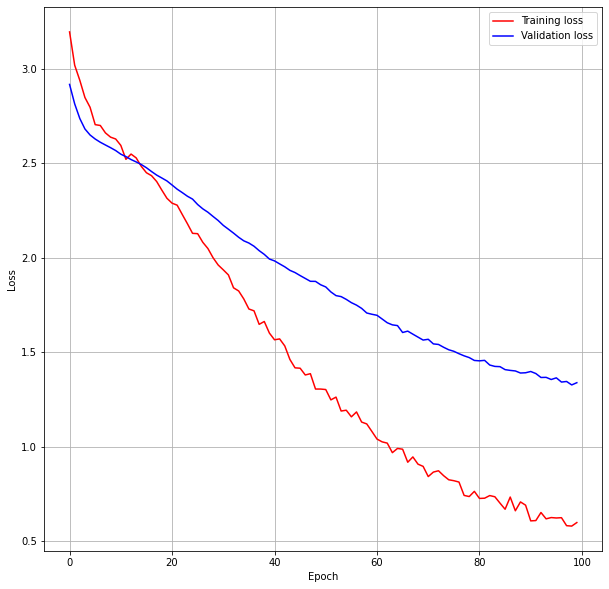

In [ ]:
plt.figure(figsize=(10, 10))

loss = historyvgg.history['loss']
val_loss = historyvgg.history['val_loss']

# plot the losses
plt.plot(loss, label='Training loss', color='red')
plt.plot(val_loss, label='Validation loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# vgg.save(os.path.sep.join([base_path,'vgg16.h5']))

Functions to predict the class and bounding box of new image and plot it

In [ ]:
def predict_image(image_path, model):
  # load the image and pre-process it
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  # predict the bounding box of the object along with the class
  (label_preds, box_preds) = model.predict(image)

  return label_preds, box_preds

def plot_image(image_path, label_pred, box_pred):
  # load the image and resize it
  image = cv2.imread(image_path)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  # scale the predicted bounding box coordinates based on the image dimensions
  bboxX, bboxY, width, height = box_pred[0]
  bboxX = int(bboxX * w)
  bboxY = int(bboxY * h)
  width = int(width * w)
  height = int(height * h)

  # get the class label
  label = label_to_class_names[np.argmax(label_pred)]

  # draw the predicted bounding box and class label on the image
  y = bboxY - 10 if bboxY - 10 > 10 else bboxY + 10
  cv2.putText(image, label, (bboxX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (bboxX, bboxY), (width, height), (0, 255, 0), 2)

  # show the output image
  cv2_imshow(image)



<font size="6"> Detecting objects using both models

**VGG predictions**

1/1 [==============================] - 1s 796ms/step
Headphones
[[0.03068644 0.04236624 0.84838116 0.73973465]]


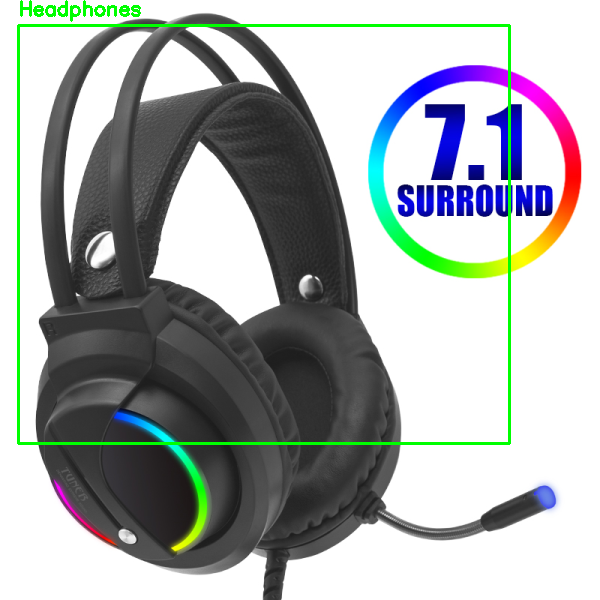

In [ ]:
headphone=os.path.sep.join([base_path,'headp.jpg'])
labelprediction, bboxprediction = predict_image(headphone,vgg)
print(label_to_class_names[np.argmax(labelprediction)])
print(bboxprediction)
plot_image(headphone,labelprediction,bboxprediction)

1/1 [==============================] - 0s 50ms/step


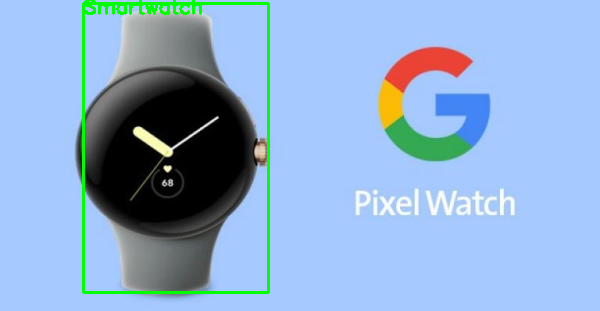

In [ ]:
watch=os.path.sep.join([base_path,'watch1.jpg'])
labelprediction, bboxprediction = predict_image(watch,vgg)
plot_image(watch,labelprediction,bboxprediction)

1/1 [==============================] - 0s 35ms/step


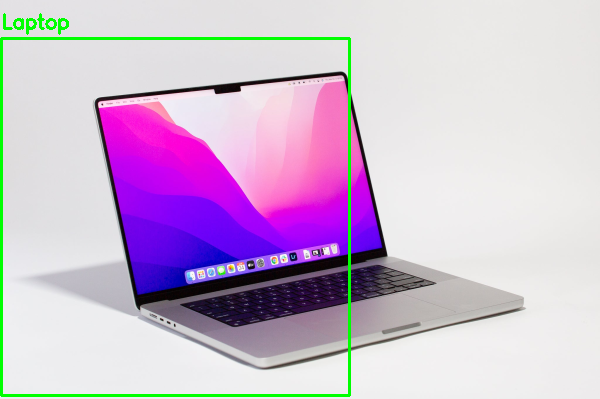

In [ ]:
lap=os.path.sep.join([base_path,'lap2.jpg'])
labelprediction, bboxprediction = predict_image(lap,vgg)
plot_image(lap,labelprediction,bboxprediction)

**MobilenetV2 Prediction**

1/1 [==============================] - 0s 22ms/step
Headphones
[[0.00670672 0.00707128 0.99992836 0.3002726 ]]


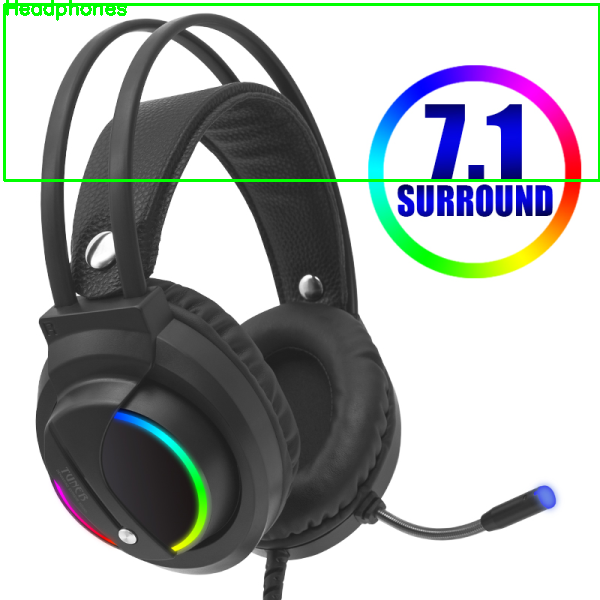

In [ ]:
headphone=os.path.sep.join([base_path,'headp.jpg'])
labelprediction, bboxprediction = predict_image(headphone,mobilenet)
print(label_to_class_names[np.argmax(labelprediction)])
print(bboxprediction)
plot_image(headphone,labelprediction,bboxprediction)

1/1 [==============================] - 0s 103ms/step


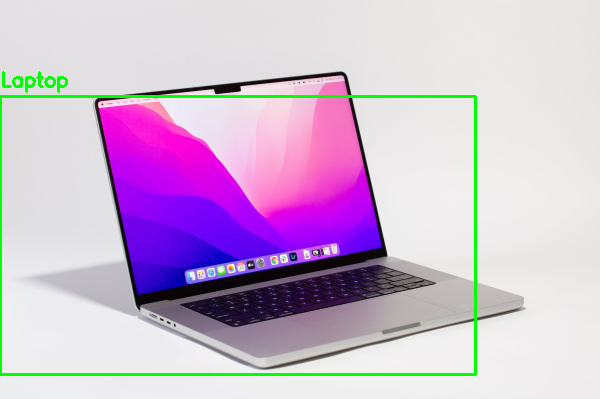

In [ ]:
lap=os.path.sep.join([base_path,'lap2.jpg'])
labelprediction, bboxprediction = predict_image(lap,mobilenet)
plot_image(lap,labelprediction,bboxprediction)

<font size="6">**Comparision Between MobilenetV2 and Vgg16 models**

We can see that both VGG 16 and mobilenetV2 are good image classification models.

VGG models are relatively large and slow to train, but they have achieved very good performance on a variety of image classification and detection tasks.

MobileNetV2 uses a combination of depthwise separable convolutions and regular convolutions to build lightweight deep neural networks that can run efficiently on mobile devices.

I have customized both the models for object detection with multiple classes to detect gadgets such as smartphones, cpu, watches etc.
I can observe that both models have performed relatevily equally however the VGG 16 model is providing us with a better overall bounding boxes, the training class label and bounding box accuracy of VGG 16 is also more than mobilenetV2.

VGG model is more accurate but slower and larger, while MobileNetV2 model is less accurate but faster and smaller

